# Pair dispersion

### Plots generated for each deployment

Taking data from `/data/drifters/spot_classified/` and chooding one date of deployment, this script generates the plots of pair dispersion and pair diffusivity

Requires `pastax` library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functions_pair_dispersion import get_trajectory, create_trajectories_and_times_list, create_mask_trajectories, temporal_interpolation, distance_pair, K_pair, apply_mask_KD, calculate_pair_separation_pair_diffusivity_and_mask_pair

import json
import os
import glob
from matplotlib.lines import Line2D
import cmocean.cm as cmo

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, Real
import xarray as xr


from pastax.gridded import Gridded
from pastax.trajectory import Location, Trajectory
from pastax.utils import distance_on_earth, meters_to_degrees

In [3]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl

rc('lines',  markersize=10)
rc("legend", fontsize=20)
rc("axes", labelsize=20)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
rc("lines", linewidth=5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

cmap = plt.colormaps["ocean"]
cmap = cmo.speed

In [4]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [6]:
project_root = os.path.abspath("..") 
data_path = os.path.join(project_root, "data", "drifters", "spot_classified")


In [15]:
## 18/05/2025
trajectories_path = data_path + '/2025-05-18/'
start_time = np.datetime64("2025-05-18T19:00:00")

## 12/05/2025




In [18]:
drifter_names = glob.glob(os.path.join(trajectories_path, '*.json'))

traj_list, trajs_times = create_trajectories_and_times_list(trajectories_path, start_time=start_time)

Interpolate in time

In [19]:
ts = np.arange(start_time, np.datetime64('now'), np.timedelta64(30,'m'))

dt = np.diff(ts)[0] # in seconds
dt = dt.astype('float')

Create a mask to know which drifters are transmitting close to the times we want to interpolate. The black areas indicate the times when we have experimental data.

Takes some time (1m40). Can be improved.

In [20]:
masks_time = create_mask_trajectories(traj_list, trajs_times, ts)

Text(0.5, 0, 'time idx')

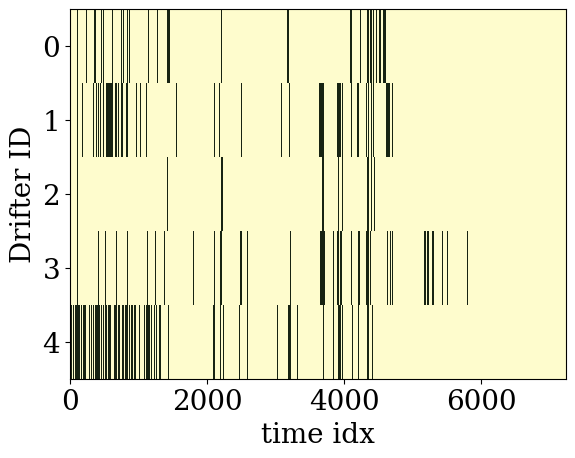

In [21]:
plt.figure()
plt.imshow(masks_time, aspect='auto', interpolation='none', cmap=cmap)
plt.ylabel('Drifter ID')
plt.xlabel('time idx')

Interpolate in time

In [22]:
interpolated_trajs = temporal_interpolation(traj_list, masks_time, ts, trajs_times)

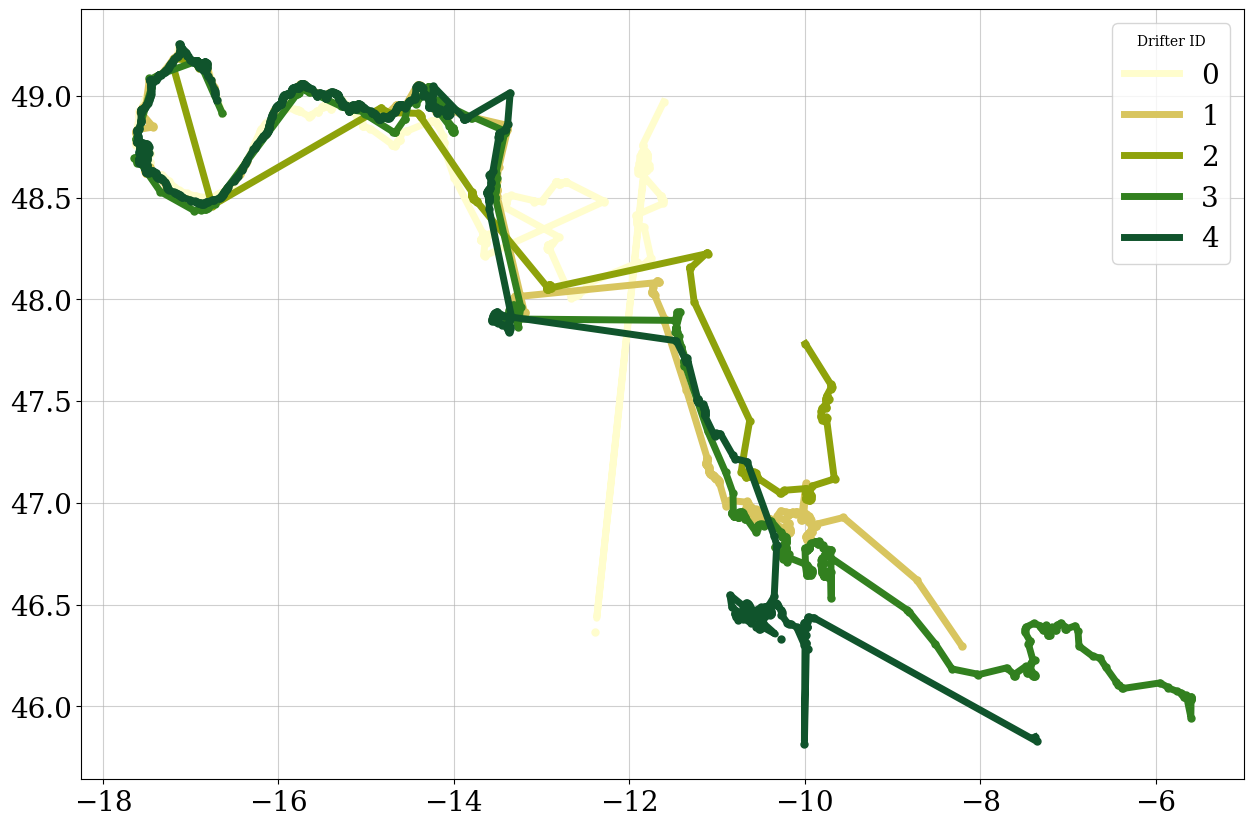

In [23]:
fig, ax = plt.subplots(figsize=(15,10))


for i in range(len(traj_list)):
    interpolated_traj = interpolated_trajs[i]
    real_traj = traj_list[i]
    plt.plot(interpolated_traj.longitudes.value, interpolated_traj.latitudes.value, c = cmap(i/len(traj_list)), label=str(i))
    plt.plot(real_traj.longitudes.value, real_traj.latitudes.value, '.', c=cmap(i/len(traj_list)))

plt.grid(alpha=0.6)
plt.legend(title='Drifter ID')

### Dispersion metrics

#### Pair diffusivity

$$ K_{ij} = \frac{1}{2}\frac{d}{dt} (D_{ij}^2) $$

In [24]:
Ds, Ks, mask_pair = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs, masks_time, dt)

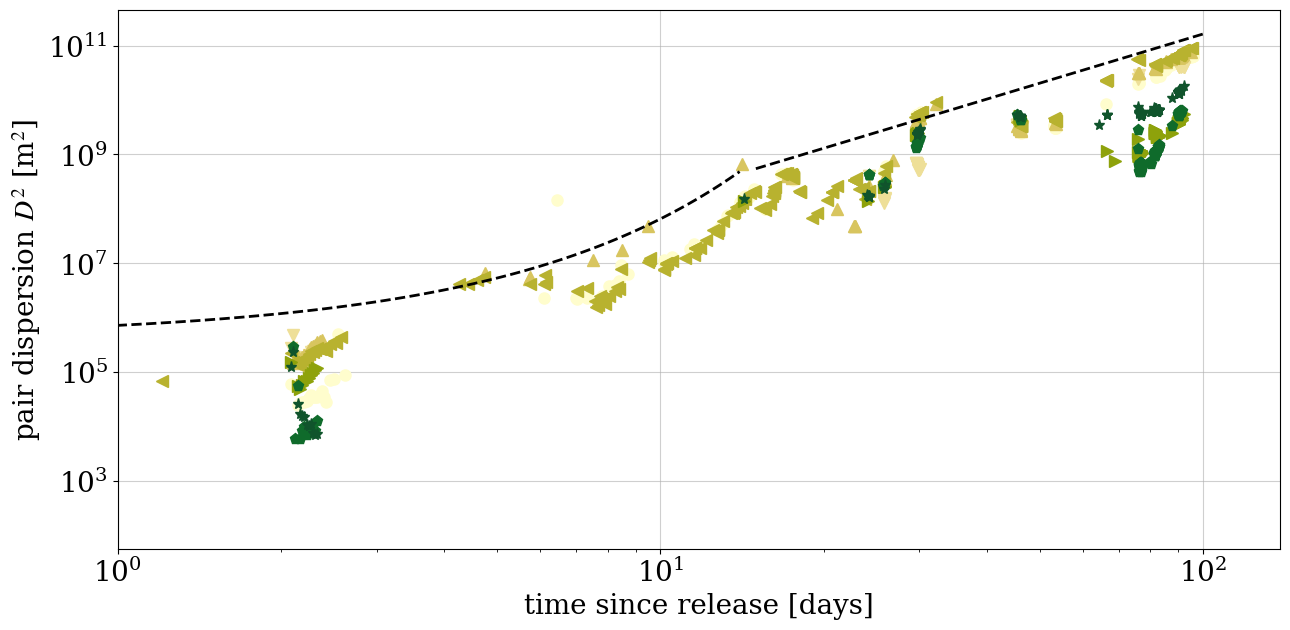

In [25]:
N = len(interpolated_trajs)
N_pairs = int(N*(N-1)/2)

markers_list = Line2D.filled_markers

plt.figure(figsize=(15,7))
for i in range(N_pairs):
    if i==6 or i==9 or i==5:
    # if i==6:
        pass
    else:
        t_pair = ts[mask_pair[i]]
        t_pair = t_pair[:-1].astype(int) - start_time.astype(int)
        t_pair_days = t_pair/(24*60*60)
        D_km = Ds[i]/1000
        #plt.plot(t_pair_days, D_km**2, c = cmap(i/N_pairs), marker=markers_list[i+1], markersize = 10, linestyle='', label=str(i))
        plt.plot(t_pair_days, Ds[i]**2, c = cmap(i/N_pairs), marker=markers_list[i+1], markersize = 8, linestyle='', label=str(i))


a = 2
t_exp = np.linspace(0, 14, 100)
plt.plot(t_exp, np.exp(t_exp/a)/np.exp(-13), 'k--', linewidth=2)

#t_ballistic = np.linspace(15, 29, 100)
#plt.plot(t_ballistic, t_ballistic**2/np.exp(-15), 'k--', linewidth=2)

t_richardson = np.linspace(15, 100, 100)
plt.plot(t_richardson, t_richardson**3/np.exp(-12), 'k--', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.6)
plt.rcParams['legend.title_fontsize'] = 20
# plt.legend(title = 'pairs', fontsize=20, loc='upper right', bbox_to_anchor=(1.15, 1))
plt.ylabel('pair dispersion $D^2$ [m$^2$]')
plt.xlabel('time since release [days]') 
plt.xlim(xmin=1)
    

In [26]:
np.sqrt(np.exp(t_exp[-1]/a)/np.exp(-12))

np.float64(13359.726829661871)

Text(0, 0.5, 'drifter diffusivity $K$ [m$^2$/s]')

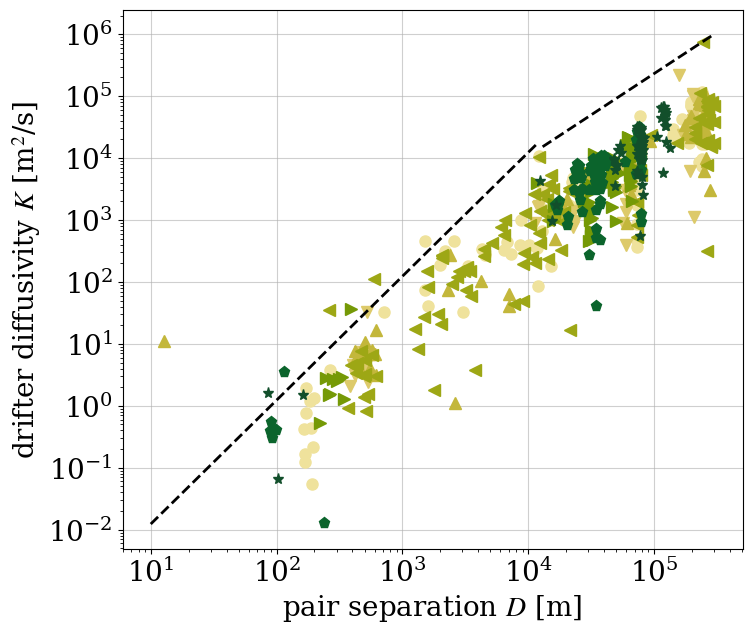

In [27]:
plt.figure( figsize=(8,7))
for i in range(N_pairs):
    if i==6 or i==9 or i==5:
    # if i==6:
        pass
    else:
        plt.plot(Ds[i], Ks[i], c = cmap((i+1)/(N_pairs+1)), marker=markers_list[i+1], markersize = 8, linestyle='',label=str(i))
    #print(markers_list[0][i])
max_dist = np.max([np.max(Ds[i]) for i in range(len(Ds))])
# d = np.arange(1, max_dist, 1000)

d_exp = np.linspace(10, 12000, 100)
plt.plot(d_exp, d_exp**2/np.exp(9), 'k--', linewidth = 2, label='exponential regime')

d_richardson = np.linspace(13000, max_dist, 100)
plt.plot(d_richardson, d_richardson**(4/3)/np.exp(3), 'k--', linewidth = 2, label='Richardson regime')

plt.xscale("log")
plt.yscale("log")

plt.grid(alpha=0.6)
#plt.legend(title = 'pairs', loc='upper right', bbox_to_anchor=(1.1, 1.))
#plt.legend()
#plt.xlim(xmin=1)

plt.xlabel('pair separation $D$ [m]')
plt.ylabel('drifter diffusivity $K$ [m$^2$/s]')


#### Finite-Scale Lyapunov Exponents (FSLE)

$$ \lambda(D) = \frac{\ln r}{\tau(D)}$$

where $D$ is the pair separation, and $\tau$ is the shortest time required for $D$ to increase by a factor of $r>1$